In [49]:
import numpy as np
from pose_evaluation_utils import * 
import quaternion
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
%matplotlib inline

rot2quat --> correct (1 test)
quat2mat --> correct (1 test) ???
mat2euler --> correct (1 test)
euler2mat --> correct (1 test)
euler2quat --> correct (1 test)

In [28]:
# rot2quat
R_test = [[ 0.92936118,  0.,         -0.36917178],
         [ 0.,          1.,          0.],
         [ 0.36917178,  0.,          0.92936118]]

q_approx = rot2quat(R_test)
q_func = R.from_matrix(R_test).as_quat()

print('DF-VO:\n {}\n\nScipy:\n {}'.format(q_approx, q_func))

DF-VO:
 (0.9821815456405263, 0.0, -0.1879345934179944, 0.0)

Scipy:
 [ 0.         -0.18793459  0.          0.98218155]


In [23]:
# quat2mat
q_test = [0.0, 0.18793459236621857, 0.0, -0.9821815490722656]
q_test_wxyz = [-0.9821815490722656, 0.0, 0.18793459236621857, 0.0]

R_approx = quat2mat(q_test_wxyz)
R_func = R.from_quat(q_test).as_matrix()
print('DF-VO:\n {}\n\nScipy:\n {}'.format(R_approx, R_func))

DF-VO:
 [[ 0.92936118  0.         -0.36917178]
 [ 0.          1.          0.        ]
 [ 0.36917178  0.          0.92936118]]

Scipy:
 [[ 0.92936118  0.         -0.36917178]
 [ 0.          1.          0.        ]
 [ 0.36917178  0.          0.92936118]]


In [18]:
# mat2euler
eul_approx = mat2euler(R_test)
eul_func = R.from_matrix(R_test).as_euler('zyx')
print('DF-VO:\n {}\n\nScipy:\n {}'.format(eul_approx, eul_func))

DF-VO:
 (-0.0, -0.37811769029318026, -0.0)

Scipy:
 [ 0.         -0.37811769  0.        ]


In [21]:
# euler2mat
eul_test = [0.0, -0.37811769029318026, 0.0]

R_fe_approx = euler2mat(*eul_test)
R_fe_func = R.from_euler('zyx', eul_test).as_matrix()
print('DF-VO:\n {}\n\nScipy:\n {}'.format(R_fe_approx, R_fe_func))

DF-VO:
 [[ 0.92936118  0.         -0.36917178]
 [ 0.          1.          0.        ]
 [ 0.36917178  0.          0.92936118]]

Scipy:
 [[ 0.92936118 -0.         -0.36917178]
 [ 0.          1.         -0.        ]
 [ 0.36917178  0.          0.92936118]]


In [22]:
# euler2quat
q_fe_approx = euler2quat(*eul_test)
q_fe_func = R.from_euler('zyx', eul_test).as_quat()
print('DF-VO:\n {}\n\nScipy:\n {}'.format(q_fe_approx, q_fe_func))

DF-VO:
 [ 0.98218155  0.         -0.18793459  0.        ]

Scipy:
 [ 0.         -0.18793459  0.          0.98218155]


In [34]:
q_test2 = rot2quat(quat2mat(q_test_wxyz))
print('Before:\n {}\n\nAfter:\n {}'.format(q_test_wxyz, q_test2))

Before:
 [-0.9821815490722656, 0.0, 0.18793459236621857, 0.0]

After:
 (0.9821815459558763, 0.0, -0.18793459176991598, 0.0)


In [89]:
q_test0 = np.array([0.0, -0.9821815459558763, 0.0, 0.18793459176991603])
q_test3 = R.from_matrix(R.from_quat(q_test0).as_matrix()).as_quat()
print('Before:\n {}\n\nAfter:\n {}'.format(q_test0, q_test3))

Before:
 [ 0.         -0.98218155  0.          0.18793459]

After:
 [ 0.          0.98218155  0.         -0.18793459]


In [78]:
x, y, z, w = 0, 0, 2, 1
s = np.sqrt(x**2 + y**2 + z**2 + w**2)
x /= s
y /= s
z /= s
w /= s

qq = np.array([x,y,z,w])
qq_ = quaternion.quaternion(w, x, y, z)
RR = R.from_quat(qq, normalized=True).as_matrix()

vec = np.array([1, 2, 0])
print(RR @ vec)
print(qq_ )

[-2.2 -0.4  0. ]
quaternion(0.447213595499958, 0, 0, 0.894427190999916)


In [87]:
from pyquaternion import Quaternion

In [104]:
def get_eul(orig_txt, target_txt):
    p = 2 * np.pi
    with open(target_txt, 'w') as w:
        with open(orig_txt, 'r') as f:
            s = 'start'
            first = True
            while(s != ''):
                if s != 'start':
                    t, x, y, z, qx, qy, qz, qw = [float(c) for c in s.split()]
                    euler = R.from_quat([qx, qy, qz, qw]).as_rotvec()
                    # .as_euler('xyz')
                    if not first:
                        deg = (euler[1] - last_euler[1])/np.pi*180 % 360
                        dif = np.sqrt(((last_pos - np.array([x, y, z]))**2).sum())
                        w.write('#{} deg: {}, dif: {}\n'.format(t, deg, dif))
                    else:
                        first = False
                    last_pos = np.array([x, y, z])
                    last_euler = np.copy(euler)
                s = f.readline()

In [105]:
get_eul('/root/DF-VO/dataset/custom/30/groundtruth.txt', '/root/DF-VO/dataset/custom/30/groundtruth_v2.txt')

In [106]:
get_eul('/root/DF-VO/results/30/30.txt', '/root/DF-VO/results/30/30_v2.txt')

In [107]:
def get_traj(txt_file, mult=1., ang_inv=False, ):
    pos, rot = [0, 0], 0
    poss = [np.copy(pos)]
    with open(txt_file, 'r') as f:
        ss = f.readline()
        while (ss != ''):
            s = ss.split()
            turn = float(s[2][:-1]) * np.pi / 180.
            if ang_inv:
                turn *= -1
            forward = float(s[4]) * mult
            pos[0] -= np.sin(rot) * forward
            pos[1] += np.cos(rot) * forward
            poss.append(np.copy(pos))
            rot += turn
            ss = f.readline()
    return np.array(poss)

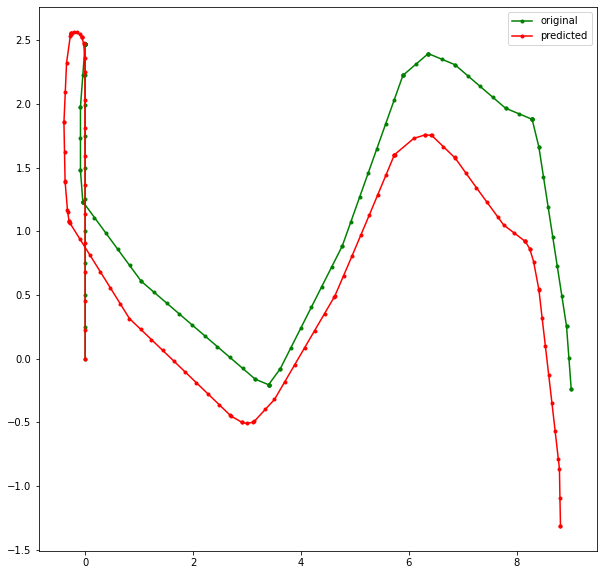

In [109]:
poss_or = get_traj('/root/DF-VO/dataset/custom/30/groundtruth_v2.txt')
poss_pred = get_traj('/root/DF-VO/results/30/30_v2.txt', 10, True)

fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(poss_or[:,0], poss_or[:,1], 'g.-', label='original')
plt.plot(poss_pred[:,0], poss_pred[:,1], 'r.-', label='predicted')
plt.legend()
plt.show()

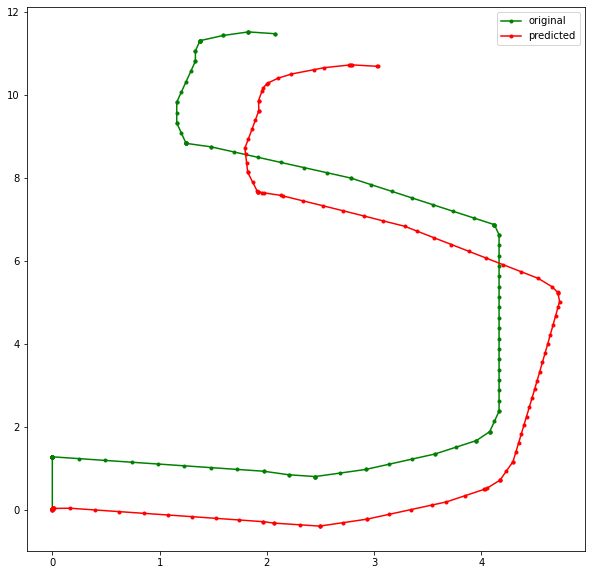

In [110]:
get_eul('/root/DF-VO/dataset/custom/34/groundtruth.txt', '/root/DF-VO/dataset/custom/34/groundtruth_v2.txt')
get_eul('/root/DF-VO/results/34/34.txt', '/root/DF-VO/results/34/34_v2.txt')

poss_or = get_traj('/root/DF-VO/dataset/custom/34/groundtruth_v2.txt')
poss_pred = get_traj('/root/DF-VO/results/34/34_v2.txt', 10, True)

fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(poss_or[:,0], poss_or[:,1], 'g.-', label='original')
plt.plot(poss_pred[:,0], poss_pred[:,1], 'r.-', label='predicted')
plt.legend()
plt.show()

In [113]:
poss_pred.shape

(125, 2)

In [114]:
poss_pred[:2]

array([[0.        , 0.        ],
       [0.        , 0.00178704]])

In [118]:
def draw_traj(num):
    get_eul('/root/DF-VO/dataset/custom/{}/groundtruth.txt'.format(num), '/root/DF-VO/dataset/custom/{}/groundtruth_v2.txt'.format(num))
    get_eul('/root/DF-VO/results/{0}/{0}.txt'.format(num, num), '/root/DF-VO/results/{0}/{0}_v2.txt'.format(num))

    poss_or = get_traj('/root/DF-VO/dataset/custom/{}/groundtruth_v2.txt'.format(num))
    poss_pred = get_traj('/root/DF-VO/results/{0}/{0}_v2.txt'.format(num), 10, True)

    fig, ax = plt.subplots(figsize=(10, 10))
    plt.plot(poss_or[:,0], poss_or[:,1], 'g.-', label='original')
    plt.plot(poss_pred[:,0], poss_pred[:,1], 'r.-', label='predicted')
    plt.legend()
    plt.show()

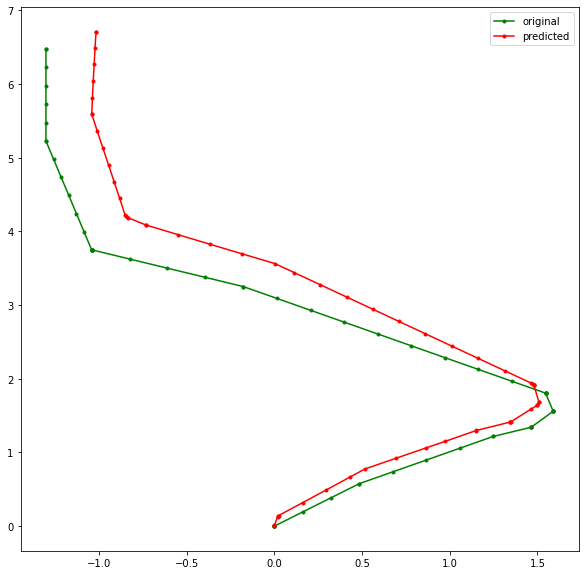

In [119]:
draw_traj(35)

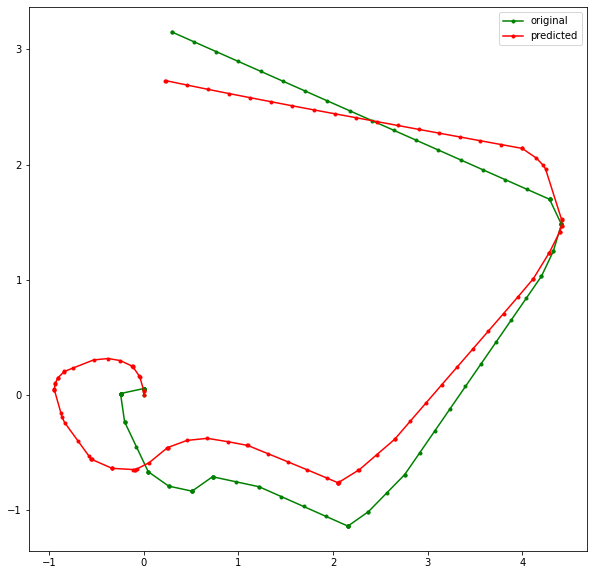

In [120]:
draw_traj(36)

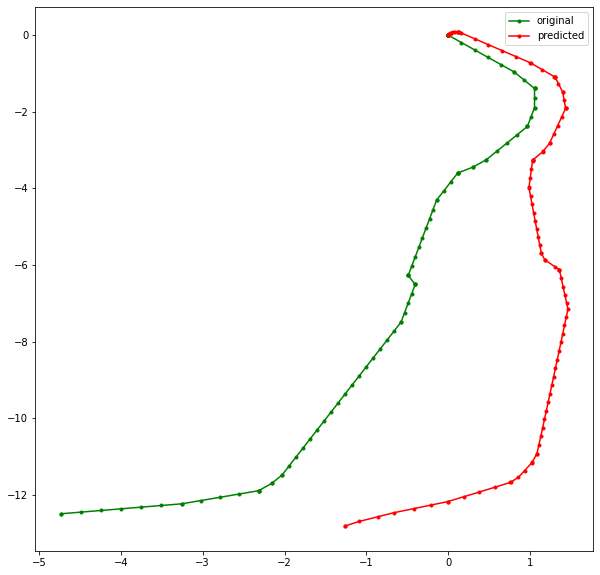

In [121]:
draw_traj(37)

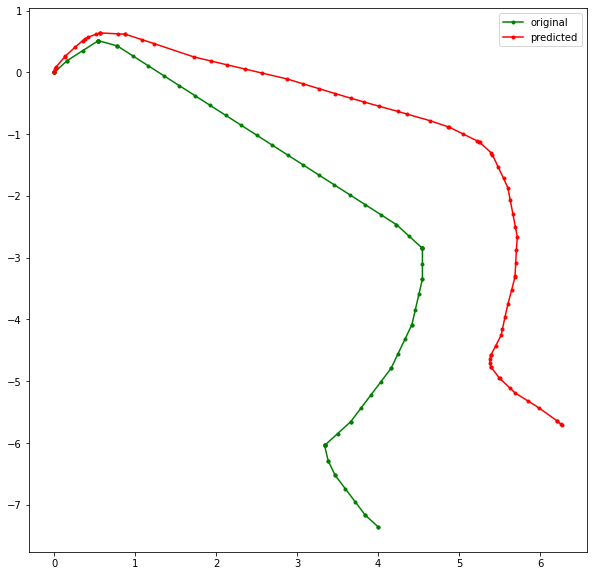

In [122]:
# IMAGE NOISE
draw_traj(38)

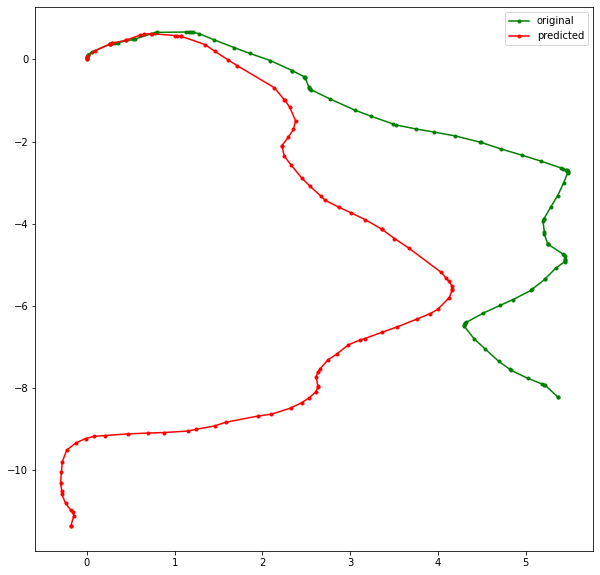

In [125]:
# ACTION NOISE
draw_traj(40)

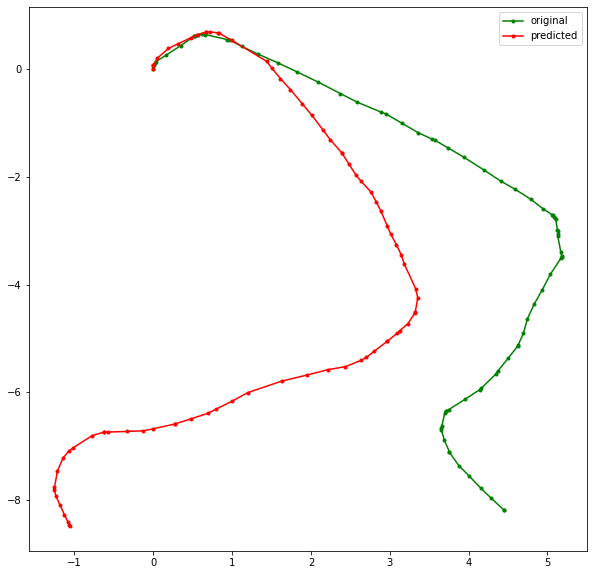

In [126]:
# ACTION AND IMAGE NOISE
draw_traj(41)

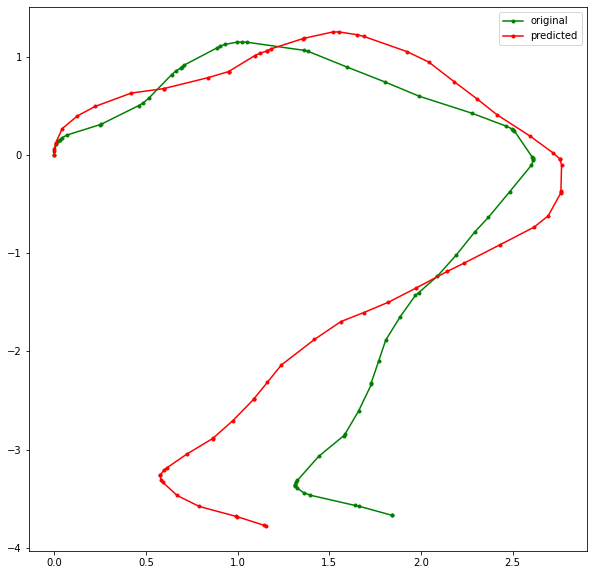

In [127]:
# ACTION AND IMAGE NOISE
draw_traj(43)

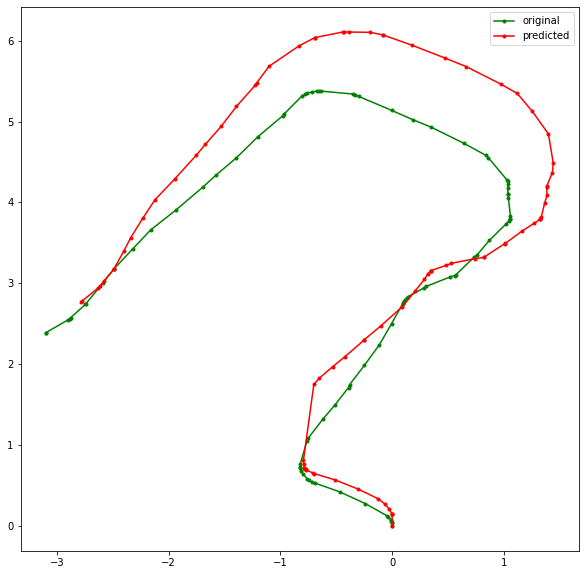

In [128]:
# ACTION AND IMAGE NOISE
draw_traj(44)

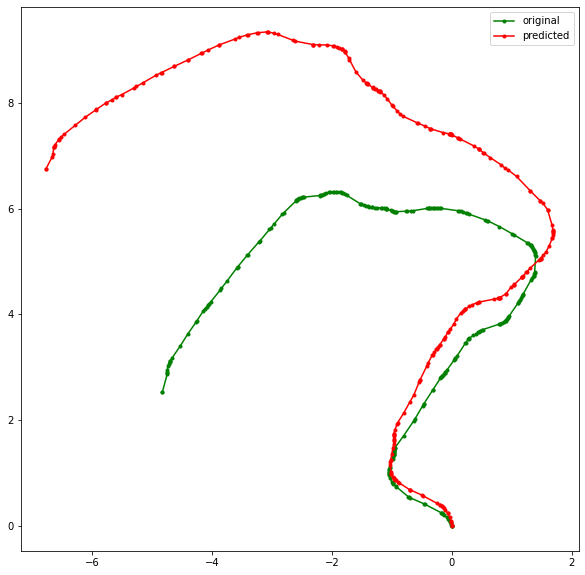

In [129]:
# ACTION AND IMAGE NOISE
draw_traj(45)